In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../healthcare_dataset.csv"

df=pd.read_csv(file_path)

df['Date of Admission']=pd.to_datetime(df['Date of Admission'])

df = df.sort_values("Date of Admission")
daily_admissions = df.groupby("Date of Admission").size().rename("admissions")

daily_admissions = daily_admissions.asfreq("D", fill_value=0)

print(daily_admissions.head())
print(daily_admissions.index.freq)

Date of Admission
2019-05-08    27
2019-05-09    38
2019-05-10    17
2019-05-11    25
2019-05-12    36
Freq: D, Name: admissions, dtype: int64
<Day>


In [2]:
test_days = 90

train = daily_admissions.iloc[:-test_days]
test  = daily_admissions.iloc[-test_days:]

print("Train:", train.index.min(), "to", train.index.max(), "len=", len(train))
print("Test :", test.index.min(),  "to", test.index.max(),  "len=", len(test))

Train: 2019-05-08 00:00:00 to 2024-02-07 00:00:00 len= 1737
Test : 2024-02-08 00:00:00 to 2024-05-07 00:00:00 len= 90


In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        admissions   No. Observations:                 1737
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -5581.456
Date:                           Mon, 29 Dec 2025   AIC                          11172.912
Time:                                   13:10:25   BIC                          11200.186
Sample:                               05-08-2019   HQIC                         11183.001
                                    - 02-07-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8017      0.277      2.890      0.004       0.258       1.345
ma.L1         -0.8138      0.271     -3.007

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_pred = sarima_forecast  # same thing, just naming

rmse = np.sqrt(mean_squared_error(test, sarima_pred))
mae  = mean_absolute_error(test, sarima_pred)
mape = np.mean(np.abs((test - sarima_pred) / test)) * 100
accuracy = 100 - mape

print("SARIMA performance on TEST set:")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape, "%")
print("Accuracy (100 - MAPE):", accuracy, "%")

SARIMA performance on TEST set:
RMSE: 6.177274942527559
MAE : 4.753656151949302
MAPE: 16.75605782378784 %
Accuracy (100 - MAPE): 83.24394217621216 %


In [6]:
sarima_df = pd.DataFrame({
    "date": test.index,
    "actual": test.values,
    "sarima_pred": sarima_pred.values
})

sarima_df.to_csv("../90 days/predictions/sarima_predictions.csv", index=False)

print("SARIMA predictions saved successfully.")

SARIMA predictions saved successfully.


In [29]:
#Rolling Series Model

test_days = 90

series = daily_admissions.sort_index()

train_series = series.iloc[:-test_days]
test_series  = series.iloc[-test_days:]

history = train_series.copy()
rolling_preds = []

for t in range(len(test_series)):
    model = SARIMAX(
        history,
        order=(1,0,1),
        seasonal_order=(1,0,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False, maxiter=200, method="lbfgs")
    y_pred = model_fit.forecast(steps=1)
    rolling_preds.append(y_pred.iloc[0])
    history = pd.concat([history, test_series.iloc[t:t+1]])

In [30]:
sarima_rolling_pred = pd.Series(
    rolling_preds,
    index=test_series.index,
    name="sarima_rolling"
)

y_test = test_series

In [31]:
rmse = np.sqrt(mean_squared_error(test_series, rolling_preds))
mae  = mean_absolute_error(test_series, rolling_preds)
mape = np.mean(np.abs((test_series - rolling_preds) / test_series)) * 100
accuracy = 100 - mape

print("Rolling SARIMA performance:")
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape)
print("Accuracy (100 - MAPE):", accuracy)

Rolling SARIMA performance:
RMSE: 6.198019460389055
MAE : 4.797184051760111
MAPE: 16.881218705800368
Accuracy (100 - MAPE): 83.11878129419964


NameError: name 'rolling_pred_series' is not defined

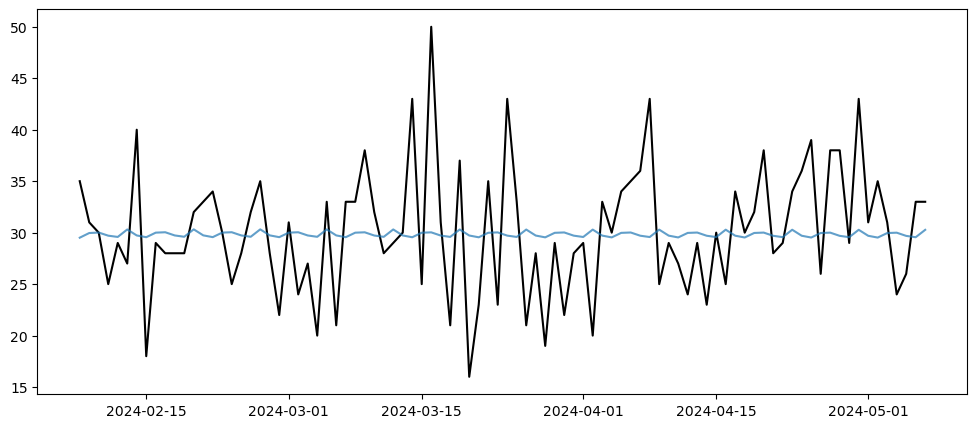

In [32]:
#Plotting

plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(test.index, sarima_pred, label="SARIMA", alpha=0.7)
plt.plot(test.index, rolling_pred_series, label="Rolling SARIMA", alpha=0.7)

plt.title("Actual vs SARIMA vs Rolling SARIMA")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.show()

In [ ]:
sarima_rolling_df = pd.DataFrame({
    "date": y_test.index,
    "actual": y_test.values,
    "sarima_rolling_pred": sarima_rolling_pred.values
})

sarima_rolling_df.to_csv("../90 days/predictions/sarima_rolling_predictions_90.csv", index=False)

print("SARIMA rolling predictions saved successfully.")


In [ ]:
actual_df = pd.DataFrame({
    "date": y_test.index,
    "actual": y_test.values
})

actual_df.to_csv("../90 days/predictions/actual_90.csv", index=False)